In [1]:
## load the required libraries
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

In [2]:
## Load the model
model_path = "iteration4_results/output/output/siamese_model"
model = tf.keras.models.load_model(model_path, compile=False)
model.summary()

Model: "SNN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_20 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 32)           941792      ['input_19[0][0]',               
                                                                  'input_20[0][0]']       

In [3]:
## load the processed training data
pairTrain = np.load("iteration4_results/output/pairTrain.npy")
labelTrain = np.load("iteration4_results/output/labelTrain.npy")
labelTrain = labelTrain.reshape(-1)

## load the raw training data
train_path = "train/farenback_of"
# train_files = os.listdir(train_path)
# print (len(train_files))

train_csv = pd.read_csv("train_aug.csv")
train_csv["of_img"] = train_csv["first_image"].apply(lambda x:x.replace("_00000001",""))

train_X = None
train_y = None
first_round = True
for i, row in train_csv.iterrows():
    img = cv2.imread(os.path.join(train_path, row["of_img"]))
    img = cv2.resize(img, (120, 120))
    target = row["target"] - 1
    if first_round: 
        train_X = [img]
        train_y = [target]
        first_round = False
    else:
        train_X = np.append(train_X,[img], axis=0)
        train_y = np.append(train_y, [target], axis=0)

del train_csv, train_path
assert train_X.shape[0] == train_y.shape[0]

In [4]:
## get model predictions on the Training data
predictTrain = model.predict([pairTrain[:, 0], pairTrain[:, 1]])

33/33 [==============================] - 4s 100ms/step


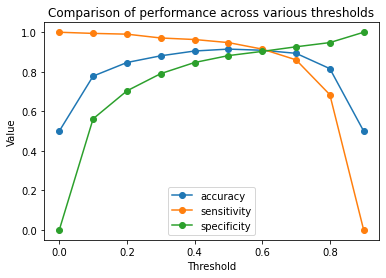

In [5]:
## check the accuracy, sensitivity and specificity for various thresholds
def plot_stats(y_train, y_train_pred):
    numbers = [float(x) / 10 for x in range(10)]
    y_train_pred_df = pd.DataFrame({"true": y_train, "pred": y_train_pred})
    for i in numbers:
        y_train_pred_df[i] = y_train_pred_df.pred.map(lambda x: 1 if x > i else 0)

    cutoff_df = pd.DataFrame(columns=["prob", "accuracy", "sensitivity", "specificity"])

    # compute the parameters for each threshold considered
    for i in numbers:
        cm1 = confusion_matrix(y_train_pred_df.true, y_train_pred_df[i])
        total1 = sum(sum(cm1))
        accuracy = (cm1[0, 0] + cm1[1, 1]) / total1

        speci = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
        sensi = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
        cutoff_df.loc[i] = [i, accuracy, sensi, speci]

    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x="prob", y=["accuracy", "sensitivity", "specificity"], style="o-")
    plt.title("Comparison of performance across various thresholds")
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.show()
    
plot_stats(labelTrain, predictTrain.reshape(-1))

Confusion Matrix: 


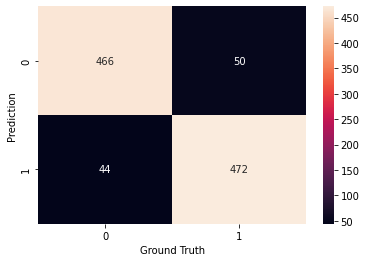

sensitivity =  0.9147286821705426
specificity =  0.9031007751937985
False positive rate =  0.09689922480620156
precision =  0.9042145593869731
accuracy =  0.9089147286821705


In [6]:
import seaborn as sns

def print_stats(y_true, y_pred, norm=None):
    '''
    Prints prediction stats like confusion-matrix, sensitivity, specificity, FPR, precision and accuracy
    '''
    # Confusion matrix
    confusion = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=norm)
    print("Confusion Matrix: ")
    if norm:
        sns.heatmap(confusion, annot=True, fmt='.1f')
    else:
        sns.heatmap(confusion, annot=True, fmt='.0f')
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.show()

    TP = confusion[1, 1]  # true positive
    TN = confusion[0, 0]  # true negatives
    FP = confusion[0, 1]  # false positives
    FN = confusion[1, 0]  # false negatives

    # Print sensitivity or recall
    sensitivity = TP / float(TP + FN)
    print("sensitivity = ", sensitivity)
    # Print specificity
    specificity = TN / float(TN + FP)
    print("specificity = ", specificity)
    # Calculate false postive rate
    fpr = FP / float(TN + FP)
    print("False positive rate = ", fpr)
    # positive predictive value
    precision = TP / float(TP + FP)
    print("precision = ", precision)
    # accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print("accuracy = ", accuracy)
    return

threshold = 0.6
predictTrain_class = [1 if i > threshold else 0 for i in predictTrain.reshape(-1)]
print_stats(labelTrain, predictTrain_class)

(49, 120, 120, 3) (49,)


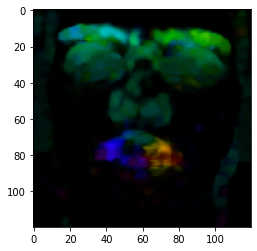

In [7]:
## Load the processed test data and the raw test data
pairTest = np.load("iteration4_results/output/pairTest.npy")
labelTest = np.load("iteration4_results/output/labelTest.npy")
labelTest = labelTest.reshape(-1)
## load only one set of training instances(to avoid duplicates)
## Note: In the training notebook, two sets of test instance-pairs were considered
pairTest = pairTest[98:]
labelTest = labelTest[98:]


test_path = "test/farenback_of"
test_csv = pd.read_csv("test_data.csv")
test_csv["of_img"] = test_csv["first_image"].apply(lambda x:x.replace("_00000001",""))

test_X = None
test_y = None
first_round = True
for i, row in test_csv.iterrows():
    img = cv2.imread(os.path.join(test_path, row["of_img"]))
    img = cv2.resize(img, (120, 120))
    target = row["target"] - 1
    if first_round: 
        test_X = [img]
        test_y = [target]
        first_round = False
    else:
        test_X = np.append(test_X,[img], axis=0)
        test_y = np.append(test_y, [target], axis=0)

test_y = test_y.astype(int)
print (test_X.shape, test_y.shape)

plt.imshow(test_X[0])
plt.show()

In [8]:
## get predictions for the test data
predictTest = model.predict([pairTest[:, 0], pairTest[:, 1]])

4/4 [==============================] - 0s 82ms/step


Confusion Matrix: 


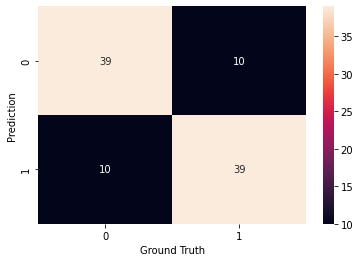

sensitivity =  0.7959183673469388
specificity =  0.7959183673469388
False positive rate =  0.20408163265306123
precision =  0.7959183673469388
accuracy =  0.7959183673469388


In [9]:
## print the prediction stats for test data with the optimal threshold based on the training data
predictTest_class = [1 if i > threshold else 0 for i in predictTest.reshape(-1)]
print_stats(labelTest, predictTest_class)

In [10]:
def return_classlabels(data_X, data_y, pairData):
    '''
    Returns the corresponding label-pair for an instance (pair of two image arrays)
    in the processed input.
    '''
    X = data_X / 255.0
    ground_truth = []
    index_pairs = []
    for i in range(pairData.shape[0]):
        img1 = pairData[i,0,:,:,:,0]
        img2 = pairData[i,1,:,:,:,0]

        inst1 = X - img1
        inst1 = inst1.sum(axis=-1).sum(axis=-1).sum(axis=-1)
        inst1 = np.where(inst1 == 0)[0][0]

        inst2 = X - img2
        inst2 = inst2.sum(axis=-1).sum(axis=-1).sum(axis=-1)
        inst2 = np.where(inst2 == 0)[0][0]
        
        ground_truth.append([data_y[inst1], data_y[inst2]])
        index_pairs.append([inst1, inst2])
    return ground_truth, index_pairs

In [11]:
train_X.shape, pairTrain.shape, test_X.shape, pairTest.shape

((516, 120, 120, 3),
 (1032, 2, 120, 120, 3, 1),
 (49, 120, 120, 3),
 (98, 2, 120, 120, 3, 1))

In [12]:
ground_truth_train, index_pairs_train = return_classlabels(train_X, train_y, pairTrain)

In [13]:
ground_truth_test, index_pairs_test = return_classlabels(test_X, test_y, pairTest)

In [14]:
len(ground_truth_train), len(ground_truth_test), len(index_pairs_train), len(index_pairs_test)

(1032, 98, 1032, 98)

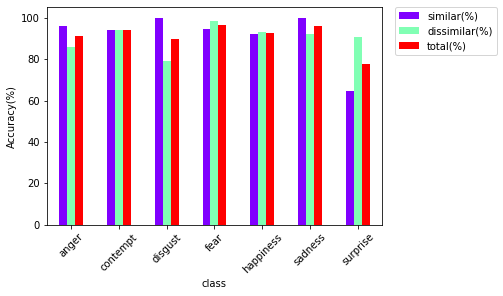

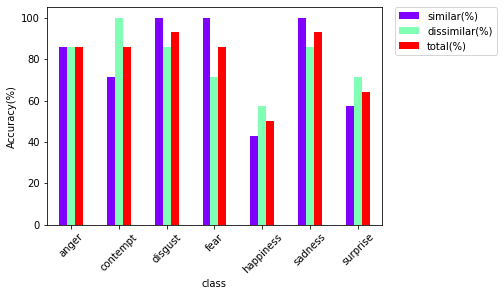

In [15]:
def plot_acc_classwise(ground_truth, label, pred):
    df = {"class":list(range(7)), 
          "similar":[0]*7, 
          "dissimilar":[0]*7, 
          "total":[0]*7,
          "similar_count":[0]*7,
          "dissimilar_count":[0]*7,
          "count":[0]*7
         }
    class_map = {0:"anger", 1:"contempt", 2:"disgust", 3:"fear", 4:"happiness", 5:"sadness", 6:"surprise"}
    total_correct = []
    for i, j, k in zip(ground_truth, label, pred):
        df["count"][i[0]] += 1
        if j == 1:
            df["similar_count"][i[0]] += 1
        if j == 0:
            df["dissimilar_count"][i[0]] += 1
        if j == k: 
            df["total"][i[0]] += 1
            if j == 1:
                df["similar"][i[0]] += 1
            if j == 0:
                df["dissimilar"][i[0]] += 1
        
        
    df = pd.DataFrame(df)
    df["similar(%)"] = 100*df["similar"]/df["similar_count"]
    df["dissimilar(%)"] = 100*df["dissimilar"]/df["dissimilar_count"]
    df["total(%)"] = 100*df["total"]/df["count"]
    df["class"] = df["class"].replace(class_map)
    
    ## plot the percentages
    cols = ["class", "similar(%)", "dissimilar(%)", "total(%)"]
    
    df[cols].plot(x="class", rot=45, kind="bar", cmap='rainbow')
    plt.legend(loc=(1.04,0.78))
    plt.ylabel("Accuracy(%)")
    plt.show()
    return df

df_train = plot_acc_classwise(ground_truth_train, labelTrain, predictTrain_class)
df_test = plot_acc_classwise(ground_truth_test, labelTest, predictTest_class)

In [16]:
del df_train, df_test, model

In [17]:
## load the feature-generation model
model_path = "iteration4_results/output/fetureExtractor"
feature_model = tf.keras.models.load_model(model_path, compile=False)
feature_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 120, 120, 32)      416       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 60, 60, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 32)        4128      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                      

In [18]:
## generate embeddings on the training data
emb = feature_model.predict(pairTrain[::2,0])
pairTrain_labels = np.array(ground_truth_train)
emb_labels = pairTrain_labels[::2,0].copy()

17/17 [==============================] - 1s 43ms/step


In [19]:
pairTrain[::2,0].shape, pairTrain_labels[::2,0].shape

((516, 120, 120, 3, 1), (516,))

In [20]:
emb.shape, emb_labels.shape

((516, 32), (516,))

In [21]:
## Analyze the features

## create a dataframe from the embeddings
features = ["F_"+str(i+1) for i in range(32)]
df_emb = pd.DataFrame(emb, columns=features)
df_emb.shape

(516, 32)

In [22]:
## add the original label column
df_emb["target"] = emb_labels
df_emb["target"].value_counts()

0    77
2    76
6    76
5    75
4    74
3    72
1    66
Name: target, dtype: int64

In [23]:
df_emb.describe()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,target
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,-2.249905,0.748684,1.154396,-1.656154,-0.947563,1.474097,1.957540,1.878071,1.669428,1.921789,...,-1.616537,1.674927,2.468450,-1.623231,2.207638,-1.150447,1.740836,0.910554,-1.757282,3.025194
std,1.921599,0.639185,0.985795,1.415769,0.809175,1.258632,1.668860,1.607231,1.423954,1.643471,...,1.380751,1.430827,2.105468,1.388072,1.885085,0.981789,1.484963,0.777774,1.504706,2.014835
min,-7.172022,-0.000035,-0.000058,-5.289827,-3.023392,0.000092,0.000231,-0.000097,-0.000088,0.000177,...,-5.152088,0.000067,0.000096,-5.192998,0.000033,-3.669962,0.000059,-0.000084,-5.616986,0.000000
25%,-3.809361,-0.000035,-0.000058,-2.809455,-1.605194,0.000092,0.000231,-0.000097,-0.000088,0.000177,...,-2.741288,0.000067,0.000096,-2.752036,0.000033,-1.949180,0.000059,-0.000084,-2.985298,1.000000
50%,-2.423285,0.805722,1.242873,-1.779613,-1.019195,1.585155,2.104206,2.020920,1.795347,2.066258,...,-1.739524,1.803000,2.651996,-1.742720,2.371698,-1.235382,1.879494,0.979476,-1.891186,3.000000
75%,0.000120,1.268569,1.957529,0.000286,0.000110,2.494485,3.317661,3.189866,2.824392,3.266499,...,0.000073,2.843230,4.183581,0.000109,3.746520,-0.000058,2.944306,1.543665,0.000141,5.000000
max,0.000120,2.387357,3.675324,0.000286,0.000110,4.703740,6.223267,6.004625,5.320963,6.135193,...,0.000073,5.330987,7.865564,0.000109,7.030558,-0.000058,5.525859,2.905226,0.000141,6.000000


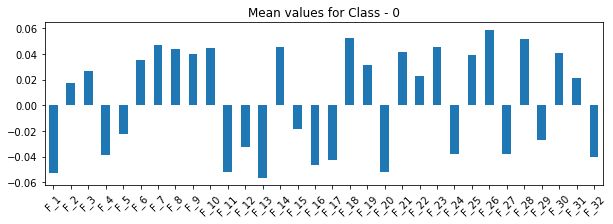

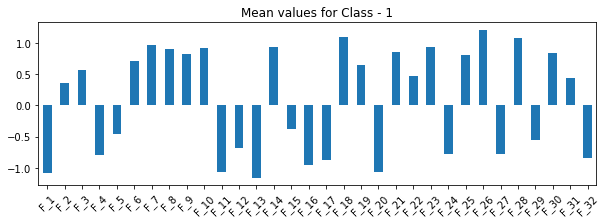

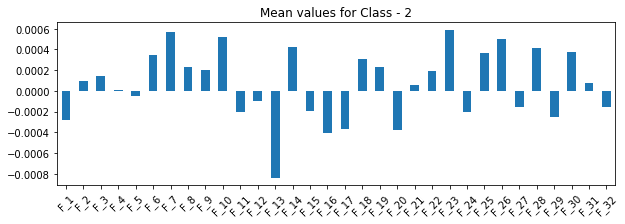

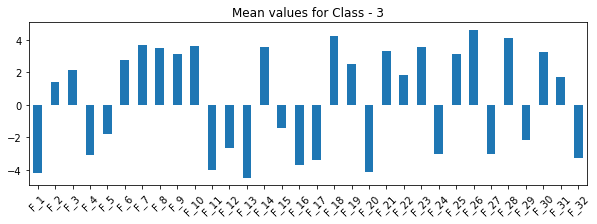

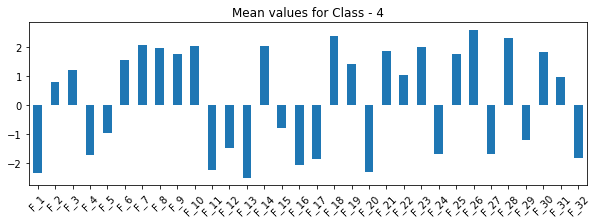

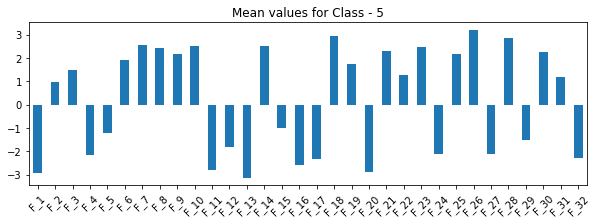

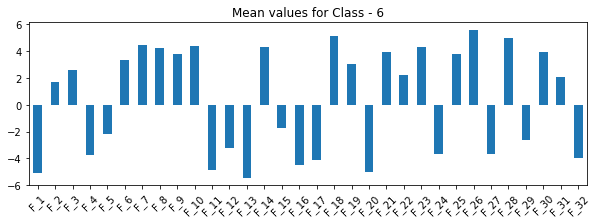

In [24]:
for i in range(7):
    plt.figure(figsize=(10,3))
    df_emb[df_emb["target"]==i][features].describe().loc["mean"].plot(kind="bar",rot=45)
    plt.title("Mean values for Class - "+str(i))
    plt.show()

In [25]:
proto_df = df_emb.groupby(by="target").mean()
proto_df.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32
target,,,,,,,,,,,,,,,,,,,,,
0,-0.052890,0.017662,0.027076,-0.038600,-0.022283,0.035024,0.046764,0.043571,0.039638,0.044933,...,0.045404,-0.037940,0.039224,0.058897,-0.037989,0.052056,-0.027385,0.040991,0.021362,-0.040431
1,-1.087401,0.362870,0.557475,-0.799638,-0.459428,0.716284,0.956534,0.897317,0.815506,0.920641,...,0.927835,-0.780906,0.805039,1.206539,-0.783691,1.070097,-0.561004,0.840597,0.440245,-0.836545
2,-0.000281,0.000096,0.000142,0.000009,-0.000054,0.000345,0.000567,0.000228,0.000200,0.000520,...,0.000590,-0.000208,0.000364,0.000504,-0.000160,0.000411,-0.000252,0.000374,0.000073,-0.000154
3,-4.202834,1.398640,2.156359,-3.095286,-1.770528,2.754133,3.656043,3.508764,3.120100,3.591470,...,3.548063,-3.017908,3.130785,4.610253,-3.036427,4.125494,-2.150240,3.247608,1.701530,-3.286434
4,-2.358888,0.784286,1.210446,-1.733270,-0.992126,1.542588,2.051173,1.966764,1.747083,2.012095,...,1.988858,-1.694681,1.757019,2.584299,-1.696050,2.310784,-1.203337,1.830449,0.953624,-1.840458


Confusion Matrix: 


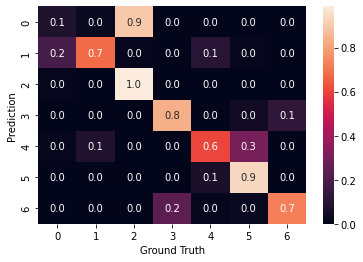

sensitivity =  0.7894736842105263
specificity =  0.7499999999999999
False positive rate =  0.25
precision =  0.963302752293578
accuracy =  0.785234899328859


In [26]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

def cosine_sim(v1, v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def return_closest_class(embedding, dist_type="euclidean"):
    distances = []
    for i in range(7):
        dist = None
        if dist_type == "euclidean":
            dist = euclidean_dist(embedding, proto_df.loc[i].to_numpy())
        elif dist_type == "cosine":
            dist = cosine_sim(embedding, proto_df.loc[i].to_numpy())
        distances.append(dist)
        
    if dist_type == "euclidean":
        return np.argmin(distances)
    elif dist_type == "cosine":
        return np.argmax(distances)
    else:
        return None

preds = []
for i in range(df_emb.shape[0]):
    preds.append(return_closest_class(df_emb[features].iloc[i], "euclidean"))
    
## check the accuracy
print_stats(df_emb["target"], preds, norm='true')

Confusion Matrix: 


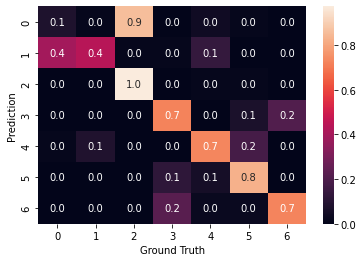

sensitivity =  0.5272727272727273
specificity =  0.8571428571428571
False positive rate =  0.14285714285714285
precision =  0.9712918660287081
accuracy =  0.5597189695550351


In [27]:
## check the accuracy
preds = []
for i in range(df_emb.shape[0]):
    preds.append(return_closest_class(df_emb[features].iloc[i], "cosine"))
    
## check the accuracy
print_stats(df_emb["target"], preds, norm='true')

The above predictions don't look good for class - 0 "anger". Moreover, most of the embeddings related to "anger" class are close to the "disgust" class. This is probably because the data considered here is too small(overfitting & noise) and visually anger and disgust classes are somewhat similar.

{0:"anger", 1:"contempt", 2:"disgust", 3:"fear", 4:"happiness", 5:"sadness", 6:"surprise"}

In [28]:
## Generate LIME explanations
len(features)

32

In [29]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=emb,
    feature_names=features,
    class_names=["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"],
    mode='classification',
    verbose=True
)

In [30]:
def predict_fn(embedding, dist_type="euclidean"):
    distances = []
    for i in range(7):
        dist = None
        if dist_type == "euclidean":
            dist = euclidean_dist(embedding, proto_df.loc[i].to_numpy())
        elif dist_type == "cosine":
            dist = cosine_sim(embedding, proto_df.loc[i].to_numpy())
        distances.append(dist)
    
    output = np.zeros(7)
    if dist_type == "euclidean":
        output[np.argmin(distances)] = 1
    elif dist_type == "cosine":
        output[np.argmax(distances)] = 1
    return output

def wrapper_fn(inp):
    output_arr = []
    for embedding in inp:
        output_arr.append(predict_fn(embedding))
    return np.array(output_arr)

In [31]:
## Generate explanations for the prototypes in each class

In [184]:
ind = np.random.randint(0,515)
print (ind)
print ("Original label:", emb_labels[ind])
exp = explainer.explain_instance(
    data_row=emb[ind], 
    predict_fn=wrapper_fn
)

exp.show_in_notebook(show_table=True)

236
Original label: 3
Intercept 0.11796116997040959
Prediction_local [-0.20823635]
Right: 0.0


In [33]:
## Generate SHAP explanations

In [34]:
import shap
shap_exp = shap.Explainer(wrapper_fn, 
                          emb, 
                          feature_names=features,
                          output_names=["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"])

In [35]:
proto_df.values.shape

(7, 32)

In [36]:
emb.shape

(516, 32)

In [37]:
shap_values = shap_exp(emb)

Permutation explainer: 517it [4:07:48, 28.82s/it]                                                                      


In [170]:
?shap.summary_plot

Class: 0


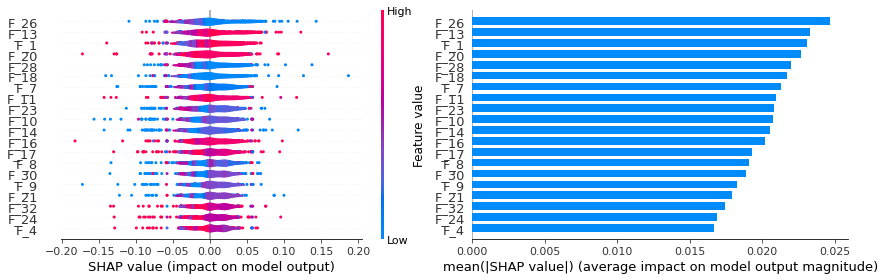

Class: 1


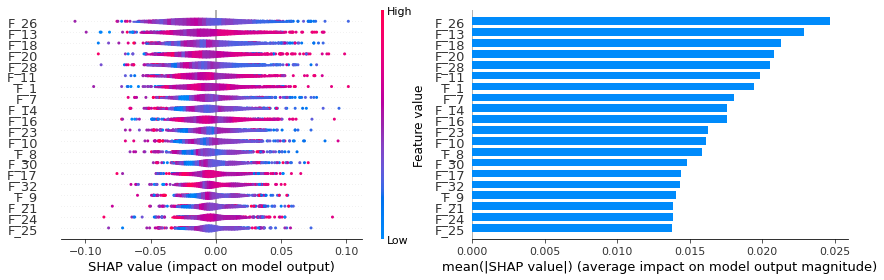

Class: 2


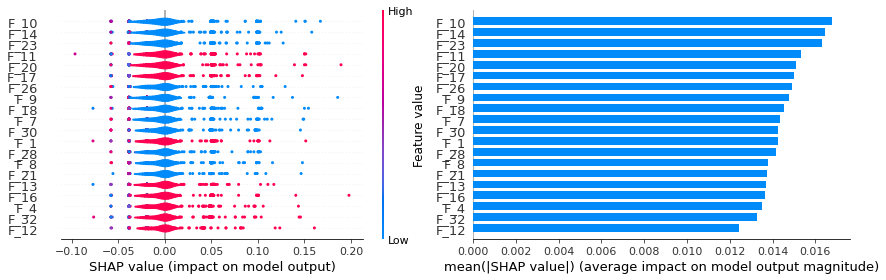

Class: 3


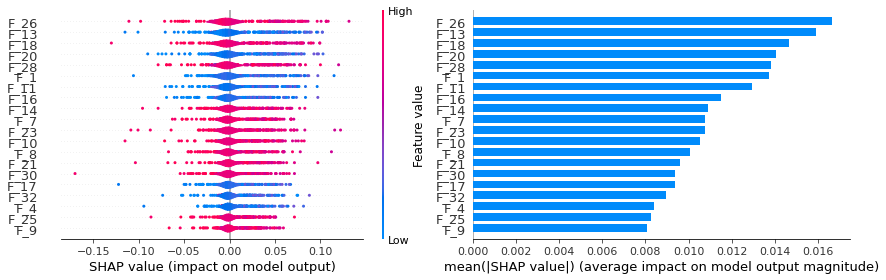

Class: 4


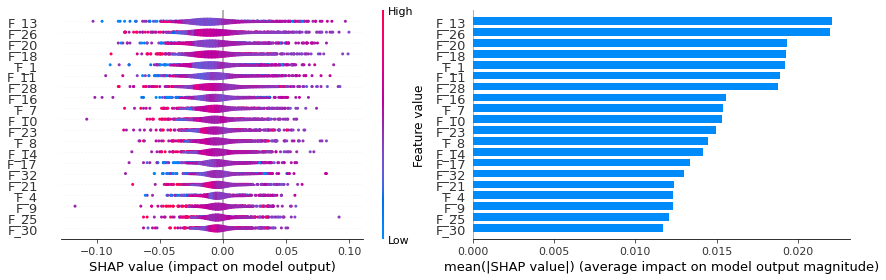

Class: 5


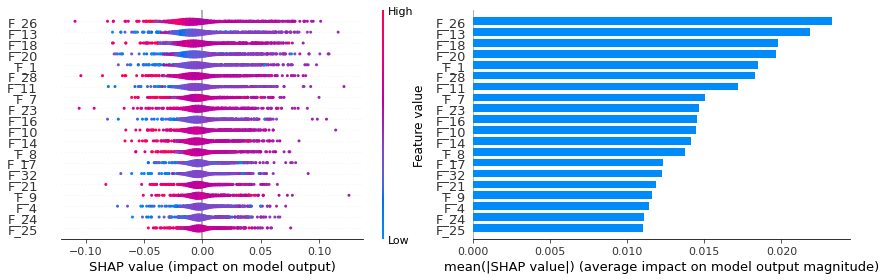

Class: 6


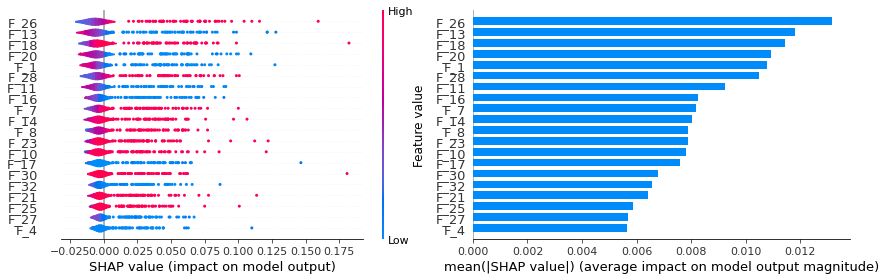

In [181]:
def plot_shap_summary(class_label):
    print ("Class:",class_label)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    shap.summary_plot(shap_values[:,:,class_label], emb, plot_type="violin", feature_names=features, plot_size=None, show=False)
    plt.subplot(1,2,2)
    shap.summary_plot(shap_values[:,:,class_label], emb, feature_names=features, plot_size=None, plot_type="bar", show=False)
    plt.show()
    return

for i in range(7):
    plot_shap_summary(i)

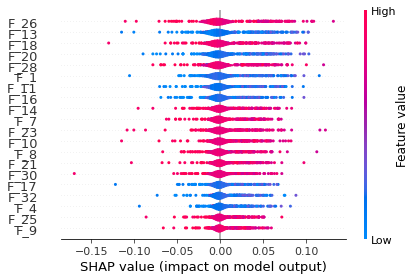

In [168]:
shap.summary_plot(shap_values[:,:,3], emb, plot_type="violin",
                  class_names=["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"], 
                  feature_names=np.array(features), plot_size=(6,4)
                  )

In [146]:
?shap.summary_plot

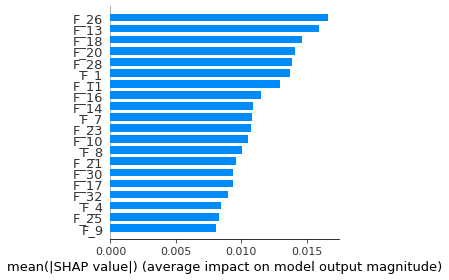

In [167]:
shap.summary_plot(shap_values[:,:,3], emb, feature_names=features, plot_size=(4,4), plot_type="bar")

In [51]:
import joblib
with open("shap_values","wb") as fp:
    joblib.dump(shap_values, fp)
    
s_values = joblib.load("shap_values")
s_values.shape

(516, 32, 7)

In [48]:
shap_values.shape

(516, 32, 7)

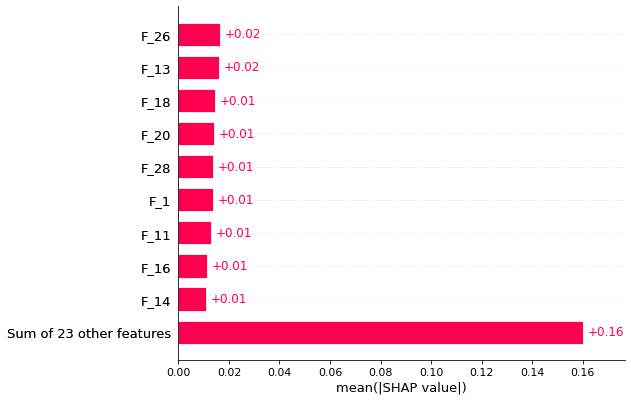

In [52]:
shap.plots.bar(shap_values[:,:,3])

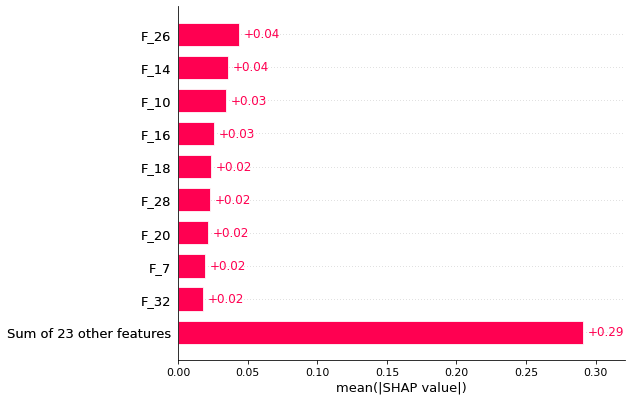

In [44]:
shap.plots.bar(shap_values[:,:,0])

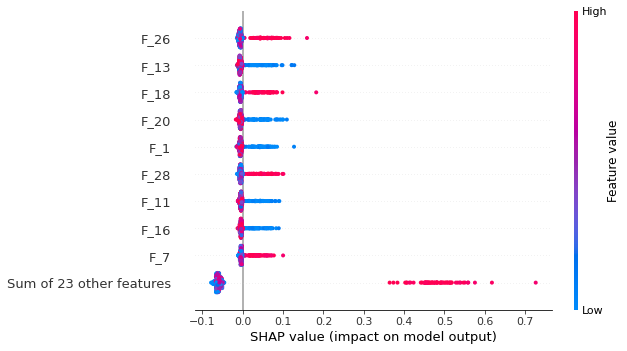

In [140]:
shap.plots.beeswarm(shap_values[:,:,6])

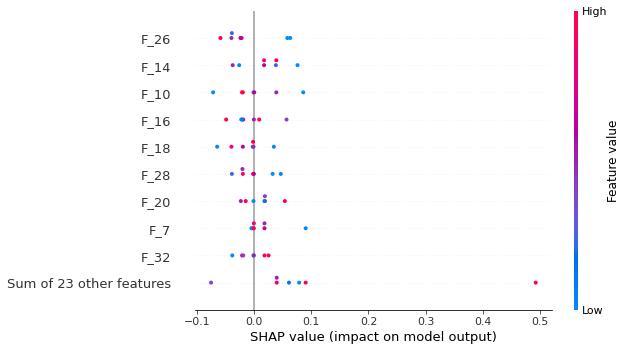

In [45]:
shap.plots.beeswarm(shap_values[:,:,0])

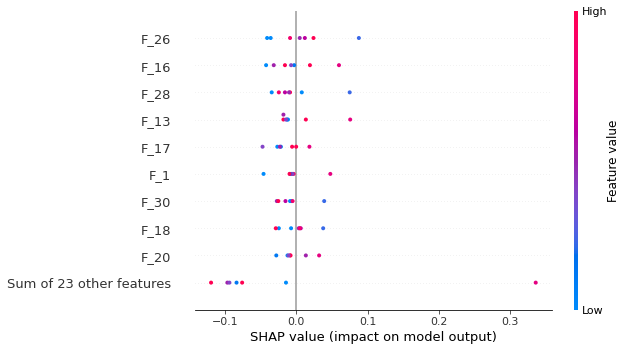

In [46]:
shap.plots.beeswarm(shap_values[:,:,1])

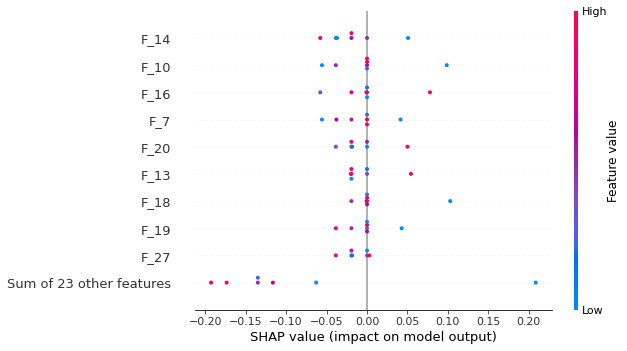

In [47]:
shap.plots.beeswarm(shap_values[:,:,2])

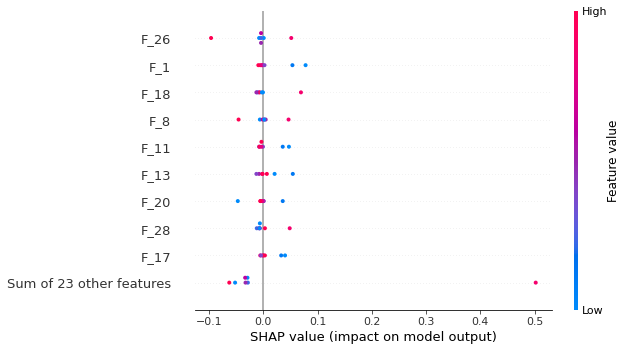

In [48]:
shap.plots.beeswarm(shap_values[:,:,3])

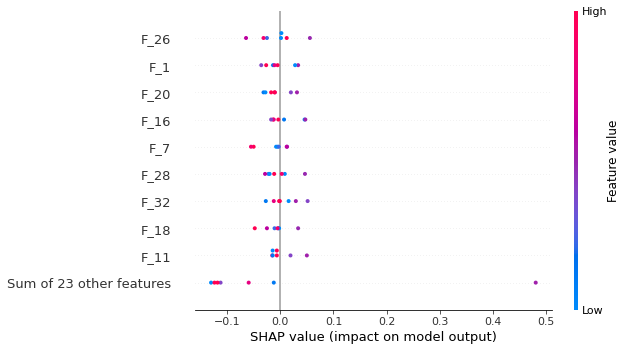

In [49]:
shap.plots.beeswarm(shap_values[:,:,4])

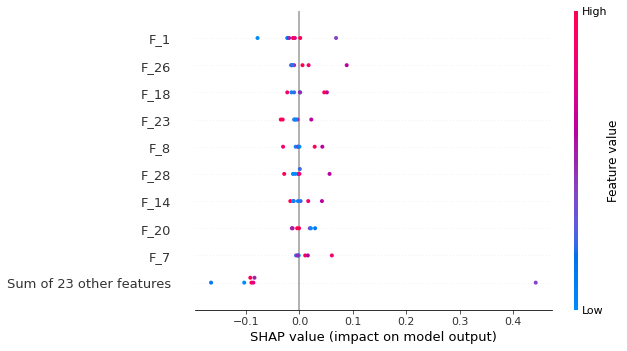

In [50]:
shap.plots.beeswarm(shap_values[:,:,5])

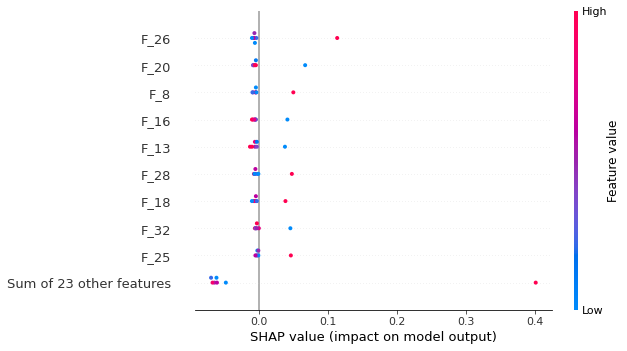

In [51]:
shap.plots.beeswarm(shap_values[:,:,6])

In [70]:
## Generate t-SNE plot on the embeddings

In [75]:
import matplotlib.patheffects as PathEffects

def feat_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [73]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
embed_tsne = TSNE(random_state=36).fit_transform(emb)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


t-SNE done! Time elapsed: 5.930822372436523 seconds


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-23.025108, 4.5428543, '0'),
  Text(-17.118893, 12.30175, '1'),
  Text(-34.10182, 6.25525, '2'),
  Text(14.513103, -11.081175, '3'),
  Text(-3.4087782, 17.759808, '4'),
  Text(18.62126, 7.325841, '5'),
  Text(6.5830126, -21.56266, '6')])

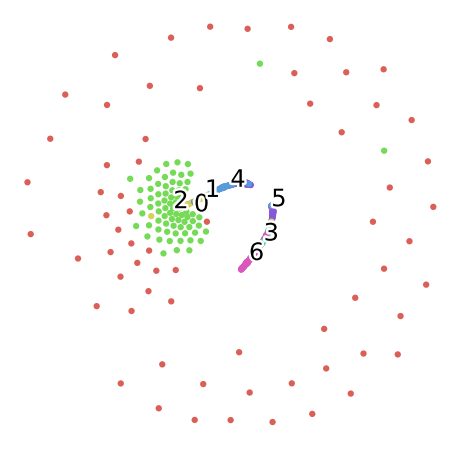

In [76]:
feat_scatter(embed_tsne, emb_labels)

In [ ]:
## Generate PCA visualizations

In [78]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(emb)

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.09503531455993652 seconds


In [79]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [9.9999052e-01 6.1322298e-06 2.0185362e-06 7.5405137e-07]


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-9.862892, -0.014146392, '0'),
  Text(-5.0392714, 0.03828356, '1'),
  Text(-9.862892, -0.014146392, '2'),
  Text(8.577454, 0.0004955475, '3'),
  Text(0.6636892, -0.00039202365, '4'),
  Text(3.0543988, -0.0068130842, '5'),
  Text(12.745579, -0.009540925, '6')])

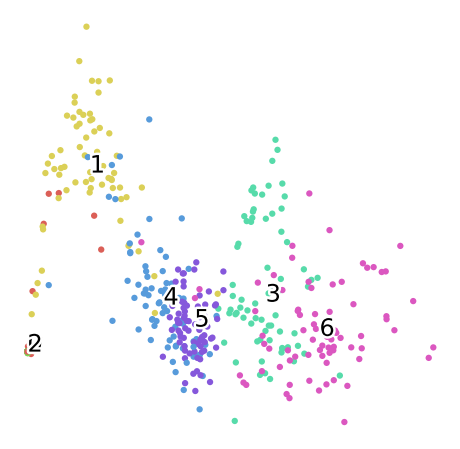

In [81]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

feat_scatter(top_two_comp.values,emb_labels) # Visualizing the PCA output